In [129]:
from __future__ import division, print_function
import logging
import warnings
import numpy as np
from astropy.stats import sigma_clip
import os
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import lightkurve as lk
from scipy import stats
from astropy import units as u
import scipy.optimize as opt
from photutils import centroids as cent


class PixelMapPeriodogram:
    """Object to hold 2D array of lk.periodgram object data .
    Attributes
    ----------
    targetpixelfile : targetpixelfile object
        
    Optional keywords accepted if ``method='lombscargle'`` are:
            ``minimum_frequency``, ``maximum_frequency``, ``minimum_period``,
            ``maximum_period``, ``frequency``, ``period``, ``nterms``,
            ``nyquist_factor``, ``oversample_factor``, ``freq_unit``,
            ``normalization``, ``ls_method``.
        
    """
    
    def __init__(self, targetpixelfile, gaia=True, magnitude_limit=18, frequencies=[], freq_unit=u.Hz , **kwargs):

        #Defining an aperture that will be used in plotting and making empty 2-d arrays of the correct size for masks
        self.aperture = targetpixelfile.pipeline_mask
        self.tpf = targetpixelfile
        #Initiating a python list since this is computational slightly faster than a numpy array when initially storing periodogram
        pg = []

        
        #Iterating through columns of pixels
        for i in np.arange(0,len(self.aperture)):
            
            #Iterating through rws of pixels
            for j in np.arange(0,len(self.aperture[0])):
                
                
                #Making an empty 2-d array
                mask = np.zeros((len(self.aperture),len(self.aperture[0])), dtype=bool)
                
                #Iterating to isolate pixel by pixel to get light curves
                mask[i][j] = True
                
                #Getting the light curve for a pixel and excluding any flagged data
                lightcurve = targetpixelfile.to_lightcurve(aperture_mask=mask)
                lc = lightcurve[np.where(lightcurve.quality == 0)]
                lc = lc.remove_outliers()
                
                #if method == 'bls':
                    #Making a periodogram for the pixel
                    #periodogram = lc.to_periodogram(method = 'bls')
                    #periodogram.power = periodogram.power / np.median(periodogram.power)
                    #periodogram.power[np.where(periodogram.power<0)] = 0
                    #Extending the list of periodogram data for each pixel
                    #pg.extend([periodogram])
                #Making a periodogram for the pixel
                periodogram = lc.to_periodogram(method ='ls', normalization='psd', frequency = frequencies*freq_unit, **kwargs)
                #periodogram= periodogram.flatten()
                
                #Extending the list of periodogram data for each pixel
                pg.extend([periodogram])
                
        #Taking the final list and turning it into a 2-d numpy array witht he same dimensions of the full postage stamp      
        pg = np.reshape(np.asarray(pg),(len(self.aperture),len(self.aperture[0])))
        
        #Defining self.periodogram as this 2-d array of periodogram data
        self.periodogram = pg
        self.timeserieslength = (self.tpf.astropy_time.max()-self.tpf.astropy_time.min()).value
        self.gaiadata = None
        
        if (gaia == True):
            """Make the Gaia Figure Elements"""
            # Get the positions of the Gaia sources
            c1 = SkyCoord(self.tpf.ra, self.tpf.dec, frame='icrs', unit='deg')
            # Use pixel scale for query size
            pix_scale = 4.0  # arcseconds / pixel for Kepler, default
            if self.tpf.mission == 'TESS':
                pix_scale = 21.0
            # We are querying with a diameter as the radius, overfilling by 2x.
            from astroquery.vizier import Vizier
            Vizier.ROW_LIMIT = -1
            result = Vizier.query_region(c1, catalog=["I/345/gaia2"],radius=Angle(np.max(self.tpf.shape[1:]) * pix_scale, "arcsec"))

            no_targets_found_message = ValueError('Either no sources were found in the query region '
                                                      'or Vizier is unavailable')
            too_few_found_message = ValueError('No sources found brighter than {:0.1f}'.format(magnitude_limit))
            if result is None:
                raise no_targets_found_message
            elif len(result) == 0:
                raise too_few_found_message
            result = result["I/345/gaia2"].to_pandas()

            result = result[result.Gmag < magnitude_limit]
            if len(result) == 0:
                raise no_targets_found_message

            year = ((self.tpf.astropy_time[0].jd - 2457206.375) * u.day).to(u.year)
            pmra = ((np.nan_to_num(np.asarray(result.pmRA)) * u.milliarcsecond/u.year) * year).to(u.deg).value
            pmdec = ((np.nan_to_num(np.asarray(result.pmDE)) * u.milliarcsecond/u.year) * year).to(u.deg).value
            result.RA_ICRS += pmra
            result.DE_ICRS += pmdec
            radecs = np.vstack([result['RA_ICRS'], result['DE_ICRS']]).T
            coords = tpf.wcs.all_world2pix(radecs, 0) 



            # Gently size the points by their Gaia magnitude
            sizes = 64.0 / 2**(result['Gmag']/5.0)
            one_over_parallax = 1.0 / (result['Plx']/1000.)
            source = dict(ra=result['RA_ICRS'],
                          dec=result['DE_ICRS'],
                          source=result['Source'].astype(str),
                          Gmag=result['Gmag'],
                          plx=result['Plx'],
                          one_over_plx=one_over_parallax,
                          x=coords[:, 0],
                          y=coords[:, 1],
                          size=sizes)


            self.gaiadata = source
        class frequency_heatmap:

            def __init__(self,pg,time_series_length,frequency_list,gaia_data):
                heat_stamp = []

                for i in np.arange(0,len(pg)):
                    for j in np.arange(0,len(pg[0])):
                        mask = np.zeros((len(pg),len(pg[0])), dtype=bool)
                        mask[i][j] = True

                        period = pg[mask][0]#.flatten(method='logmedian',filter_width = .1)
                        normperiod = np.asarray(period.power)#/np.nanmedian(np.asarray(period.power))
                        freq = np.asarray(period.frequency)
                        sums = normperiod.sum()
                        background = 0
                        
                            #background += len(np.where((freq < frequency_list[k]+(1/(2*time_series_length)) ) & (freq > frequency_list[k]-(1/(2*time_series_length))))[0])#*np.nanmedian(np.asarray(period.power))
                        heat_stamp.extend([sums-background])

                self.heat_stamp = np.reshape(np.asarray(heat_stamp),(len(pg),len(pg[0])))
                self.gaiadata=gaia_data
            def centroid(self):
                #same sigma, assuming symmetrical distributed psf
                def two_dGaussian( shape , amplitude, xo, yo, sigma):
                    x,y = np.meshgrid(shape[0],shape[1])
                    xo = float(xo)
                    yo = float(yo)    
                    a = 1/(2*sigma**2)
                    g = np.abs(amplitude)*np.exp( - (a*((x-xo)**2) + a*((y-yo)**2)))
                    return g.flatten()

                c = cent.centroid_2dg(self.heat_stamp)
                x = np.arange(0,np.shape(self.heat_stamp)[0])
                y = np.arange(0,np.shape(self.heat_stamp)[1])

                initial_guess = (self.heat_stamp.max(),c[0],c[1],1)
                popt, pcov = opt.curve_fit(two_dGaussian, (x,y),self.heat_stamp.flatten(), p0=initial_guess)

                self.x = popt[1]
                self.y = popt[2]
                self.sigma = popt[3]
                self.covariance=pcov
            def star_list(self):
                gaia_data = self.gaiadata
                no_gaia_data_message = ValueError('No gaia data initialized in PixelMapPeriodogram class')
                if gaia_data ==None :
                    raise no_gaia_data_message

                else:    
                    closest_star_mask = np.where(np.square(self.x-gaia_data['x'])+np.square(self.y-gaia_data['y'])==(np.square(self.x-gaia_data['x'])+np.square(self.y-gaia_data['y'])).min())
                    stars = dict(ra = np.asarray(gaia_data['ra']),
                                 dec = np.asarray(gaia_data['dec']),
                                 source = np.asarray(gaia_data['source']),
                                 x = np.asarray(gaia_data['x']),
                                 y = np.asarray(gaia_data['y']),
                                 distance = np.square(self.x-gaia_data['x'])+np.square(self.y-gaia_data['y']))
                    starlist = pd.DataFrame.from_dict(stars)
                    self.stars = starlist.sort_values(by=[r'distance'])
                    
        fh = frequency_heatmap(self.periodogram,self.timeserieslength,frequencies,self.gaiadata) 
        fh.centroid()
        fh.star_list()
        self.centroid = [fh.x,fh.y]
        self.heatmap = fh.heat_stamp
        self.starfit= fh.stars.reset_index()
    
    def info(self):
        plt.imshow(self.heatmap,origin=0)
        #plot the centroid
        if (self.gaiadata != None):
            plt.scatter(self.gaiadata['x'],self.gaiadata['y'],s=self.gaiadata['size']*5,c='white',alpha=.6)
            plt.scatter(self.centroid[0],self.centroid[1],marker='X',s=100,c='red')
        plt.xlim(-.5,self.aperture.shape[1]-1+.5)
        plt.ylim(-.5,self.aperture.shape[0]-1+.5)
        self.starfit

            
        
    def plot(self):
        """
        Returns a plot of Frequency power spectrums for each pixel.
        """
        fig,ax = plt.subplots(len(self.aperture[0]),
                      len(self.aperture[1]),
                      figsize=(20,20),sharex='col', sharey='row')

        #Just making the subplot spacings 0 pixel width and height separation
        fig.subplots_adjust(wspace=0,hspace=0)
    
    
        #iterating through the columns of the postage stamp pixels
        for i in np.arange(0,len(self.aperture[0])):
    
            #iterating through the rows of the postage stamp pixels
            for j in np.arange(0,len(self.aperture[1])):
        
                #Creating a false mask to alter each iteration
                mask = np.empty((len(self.aperture),len(self.aperture[0])), dtype=bool)
            
                #setting one pixel in the postage stamp to have a lightcurve extracted and plotted
                mask[i][j] = True
                                  
        
                #Plotting the target pixel periodograph -- This can also be set up to have looks based on user input if desired
                ax[i][j].plot(self.periodogram[i][j].frequency,self.periodogram[i][j].power);
                
        
        



In [38]:
search_result = lk.search_targetpixelfile('TIC117070953')
tpf = search_result.download(quality_bitmask='default')

In [130]:
pmp1 = PixelMapPeriodogram(tpf, frequencies= [9.51112996, 19.02225993, 28.53338989, 38.04451986, 47.55564982, 57.06677979, 66.57790975, 76.08903972],freq_unit=u.microHertz)

C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\lightcurve.py:694: LightkurveWarning: The light curve has a negative median flux (-5.61e+01); `normalize()` will therefore divide by a negative number and invert the light curve, which is probablynot what you want
  LightkurveWarning)
C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\lightcurve.py:694: LightkurveWarning: The light curve has a negative median flux (-1.40e+01); `normalize()` will therefore divide by a negative number and invert the light curve, which is probablynot what you want
  LightkurveWarning)
C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\lightcurve.py:694: LightkurveWarning: The light curve has a negative median flux (-4.83e+01); `normalize()` will therefore divide by a negative number and invert the light curve, which is probablynot what you want
  LightkurveWarning)
C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\lightcurve.py:694: LightkurveWarning: The light curve has a negative median flu

C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\lightcurve.py:694: LightkurveWarning: The light curve has a negative median flux (-1.42e+01); `normalize()` will therefore divide by a negative number and invert the light curve, which is probablynot what you want
  LightkurveWarning)
C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\lightcurve.py:694: LightkurveWarning: The light curve has a negative median flux (-4.50e+00); `normalize()` will therefore divide by a negative number and invert the light curve, which is probablynot what you want
  LightkurveWarning)
C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\lightcurve.py:694: LightkurveWarning: The light curve has a negative median flux (-6.02e+01); `normalize()` will therefore divide by a negative number and invert the light curve, which is probablynot what you want
  LightkurveWarning)
C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\lightcurve.py:694: LightkurveWarning: The light curve has a negative median flu

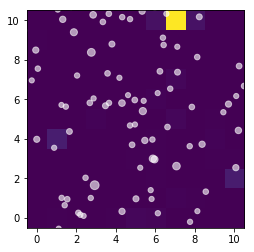

In [131]:
pmp1.info()

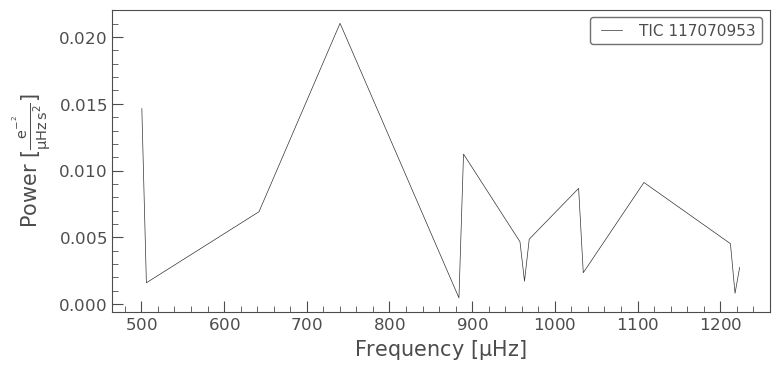

In [113]:
pmp1.periodogram[7][3].plot()

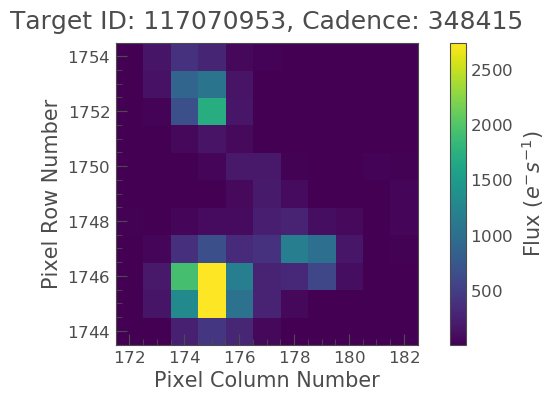

In [124]:
tpf.plot()